# Lab Demonstration 1  
## Fractals with Tensorflow

### Vincent Abbosh /  45019218

In [3]:
import tensorflow as tf
tf.__version__

'1.14.0'

## Part 1

In [2]:
import numpy as np

sess = tf.InteractiveSession()

#### Producing a 2D Gaussian image

In [3]:
X, Y = np.mgrid[-4.0:4:0.01, -4.0:4:0.01]

In [4]:
xs = tf.constant(X.astype(np.float32))
ys = tf.constant(Y.astype(np.float32))

In [5]:
tf.global_variables_initializer().run() #init variables

In [6]:
zs = tf.exp(-(xs**2+ys**2)/2.0)

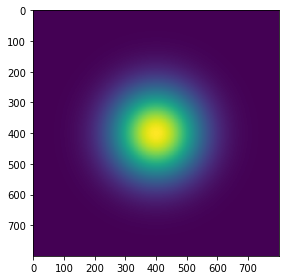

In [8]:
#plot
import matplotlib.pyplot as plt
plt.imshow(zs.eval())
plt.tight_layout()
plt.show()

#### Use $sin(x)$

In [9]:
zs_sin = tf.sin(xs**2 + ys**2)

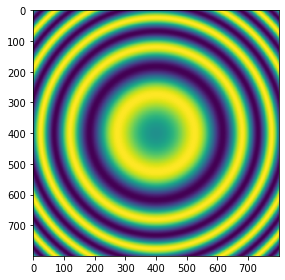

In [10]:
plt.imshow(zs_sin.eval())
plt.tight_layout()
plt.show()

### Plot $e^{-\frac{r^2}{\sigma}}sin(r^2)$

In [11]:
zs_prod = zs * zs_sin

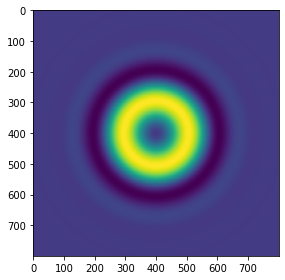

In [12]:
plt.imshow(zs_prod.eval())
plt.tight_layout()
plt.show()

## Part 2

In [13]:
Y1, X1 = np.mgrid[-1.3:1.3:0.001, -2:1:0.001]
Z1 = X1+1j*Y1

In [20]:
xs_const = tf.constant(Z1.astype(np.complex64))
zs_var = tf.Variable(xs_const)
ns_var = tf.Variable(tf.zeros_like(xs_const, tf.float32))

In [21]:
tf.global_variables_initializer().run()

In [22]:
zs_ = zs_var*zs_var + xs_const

In [23]:
not_diverged = tf.abs(zs_) < 2

In [26]:
step = tf.group( zs_var.assign(zs_), ns_var.assign_add(tf.cast(not_diverged, tf.float32)) )

In [27]:
for i in range(200):
    step.run()
    

In [28]:
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic), 30+50*np.sin(a_cyclic), 155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

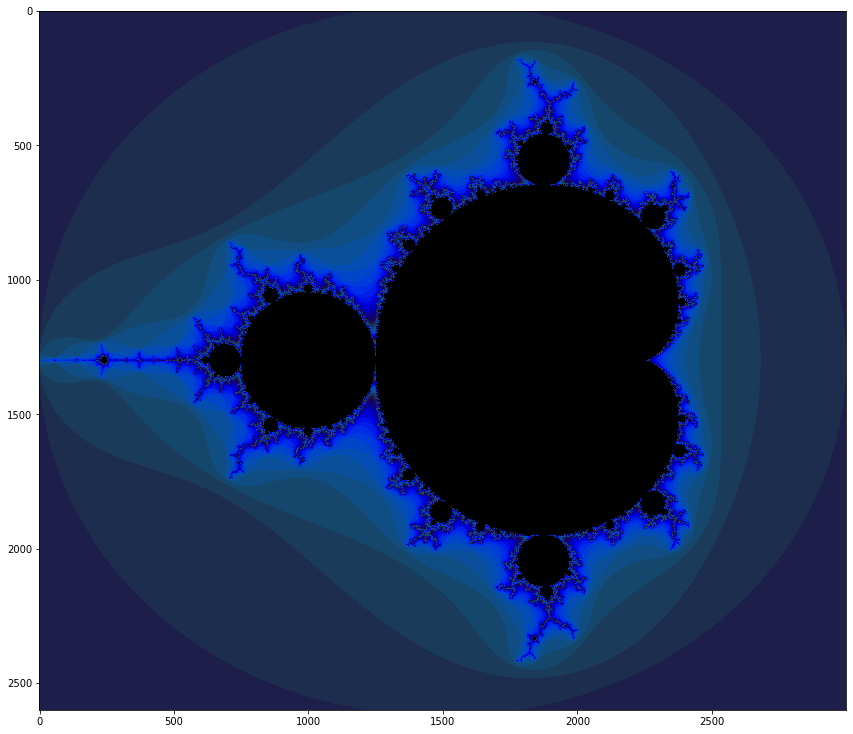

In [29]:
fig = plt.figure(figsize=(16,10))
plt.imshow(processFractal(ns_var.eval()))
plt.tight_layout(pad=0)
plt.show()

#### Zooming in

In [30]:
Y2, X2 = np.mgrid[0.2:0.7:0.0001, 0:0.5:0.0001]
Z2 = X2+1j*Y2

In [31]:
xs_const = tf.constant(Z2.astype(np.complex64))
zs_var = tf.Variable(xs_const)
ns_var = tf.Variable(tf.zeros_like(xs_const, tf.float32))

In [32]:
tf.global_variables_initializer().run()

In [33]:
zs_ = zs_var*zs_var + xs_const
not_diverged = tf.abs(zs_) < 2
step = tf.group( zs_var.assign(zs_), ns_var.assign_add(tf.cast(not_diverged, tf.float32)) )

In [34]:
for i in range(200):
    step.run()

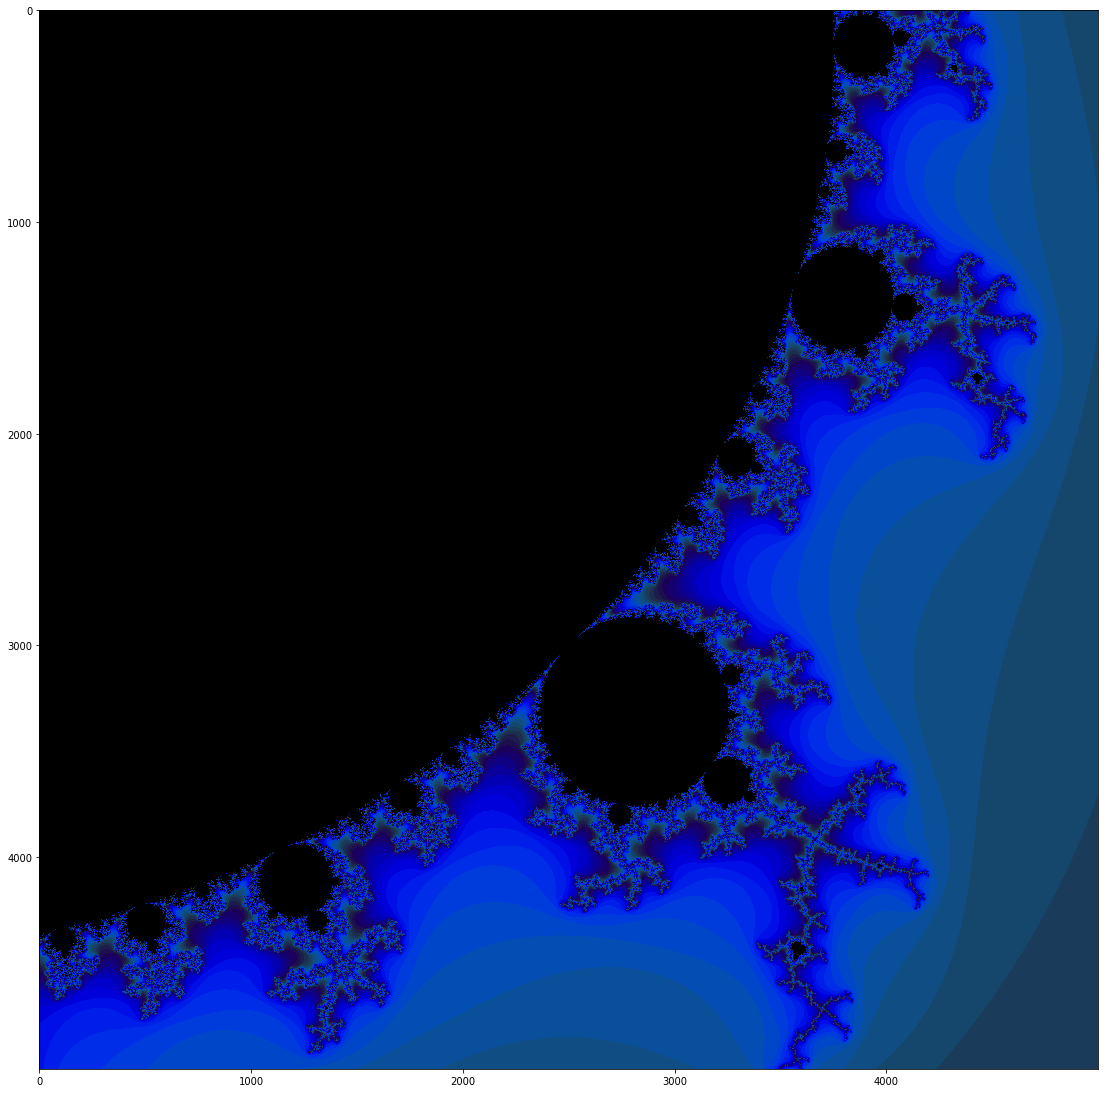

In [35]:
fig = plt.figure(figsize=(15,15))
plt.imshow(processFractal(ns_var.eval()))
plt.tight_layout(pad=0)
plt.show()

#### Julia set

Set $c = (\Phi - 2) + (\Phi - 1)i = -0.4 + 0.6i$ where $\Phi$ is the Golden ratio

In [36]:
Y3, X3 = np.mgrid[-1.3:1.3:0.001, -2:2:0.001]
Z3 = X3+1j*Y3

c = -0.4 + 1j*0.6

In [37]:
xs_const = tf.constant(c)
zs_var = tf.Variable(Z3)
ns_var = tf.Variable(tf.zeros_like(zs_var, tf.float32))

In [38]:
tf.global_variables_initializer().run()

In [39]:
zs_ = zs_var*zs_var + xs_const
not_diverged = tf.abs(zs_) < 2
step = tf.group( zs_var.assign(zs_), ns_var.assign_add(tf.cast(not_diverged, tf.float32)) )

In [40]:
for i in range(200):
    step.run()

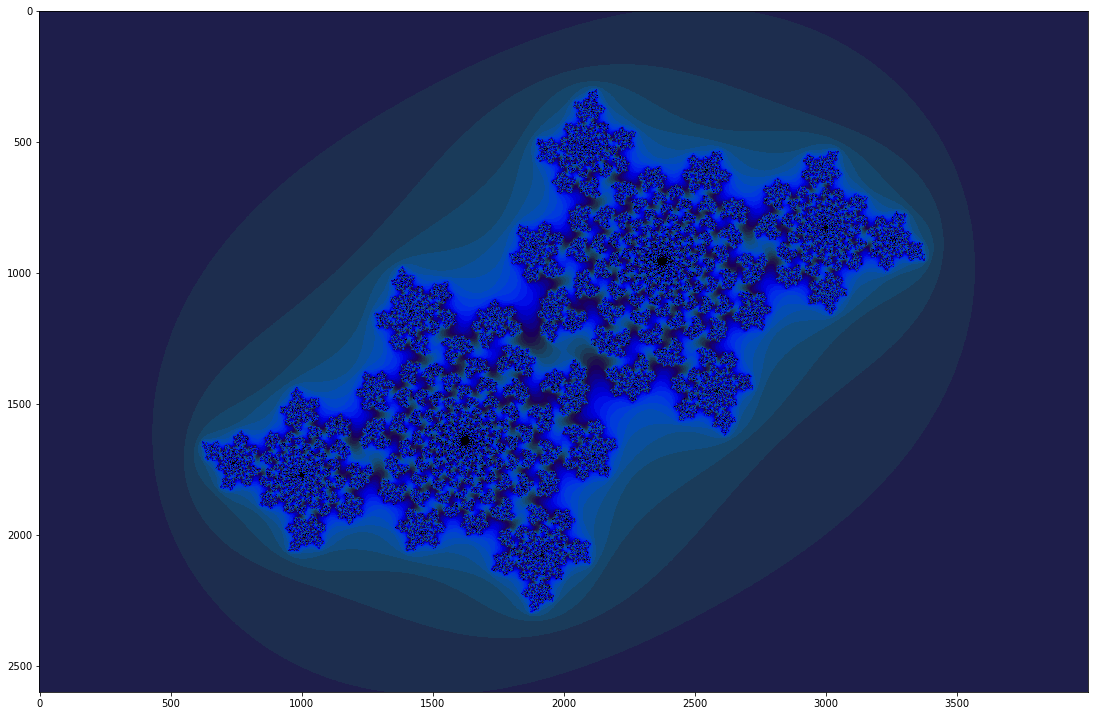

In [41]:
fig = plt.figure(figsize=(15,10))
plt.imshow(processFractal(ns_var.eval()))
plt.tight_layout(pad=0)
plt.show()

In [42]:
sess.close()

## Part 3
### Barnesley Fern using IFS (Iterated Function Systems)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
sess2 = tf.InteractiveSession()

To produce each part of the fern, an affine transformation is chosen based on a probability distribution.  
Applying an affine transformation on a point $x_n = (x_{1}, x_{2})^T$ is equivalent to the matrix operation below:  
$x_{n+1} = \begin{bmatrix}a&b\\c&d\end{bmatrix} x_n + \begin{bmatrix}e\\f\end{bmatrix}$ where $a, b, c, d, e, f$ parameters are taken from table 5.48 for Figure 5.25 on page 317 in the "Fractals For The Classroom" book.  

The affine transformation above can be re-written with just one matrix/vector multiplication by augmenting $x_n$ to be $(x_1, x_2, 1)^T$ and adding $(e, f)$ as a third column and adding a third row of $(0, 0, 1)$ to keep the transformation matrix square with a 3x3 shape:  

$x_{n+1} = \begin{bmatrix}a&b&e\\c&d&f\\0&0&1\end{bmatrix} \begin{bmatrix}x_n\\1\end{bmatrix}$  

To build the fern, we need to start from a point, could be $(0,0)$, and iterate through the 4 different transformations, $\bf w_i$, with each is selected based on a probability $p_i$ for $i \in {1,2,3,4}$ as shown in Figure 6.25 in the book, which was reproduced below:


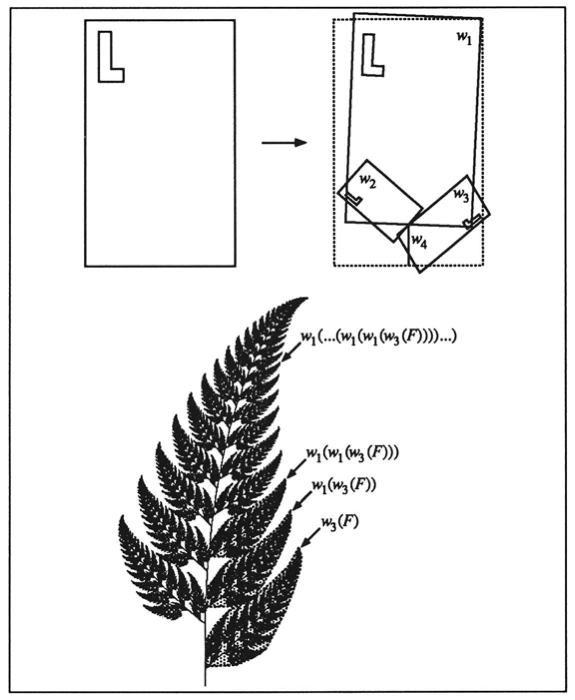

In [3]:
tf_w1 = tf.constant([[0.849, 0.037, 0.075],
                     [-0.037, 0.849, 0.183],
                     [0.0, 0.0, 1.0]], dtype=tf.float32) # main body

tf_w2 = tf.constant([[0.197, -0.226, 0.4],
                     [0.226, 0.197, 0.049],
                     [0.0, 0.0, 1.0]], dtype=tf.float32) # left leaf

tf_w3 = tf.constant([[-0.15, 0.283, 0.575],
                     [0.26, 0.237, -0.084],
                     [0.0, 0.0, 1.0]], dtype=tf.float32) # right leaf

tf_w4 = tf.constant([[0.0, 0.0, 0.5],
                     [0.0, 0.16, 0.0],
                     [0.0, 0.0, 1.0]], dtype=tf.float32) # The stem

# pack them in an array of transforms
tf_transforms = [tf_w1, tf_w2, tf_w3, tf_w4]

In [4]:
tf_transforms

[<tf.Tensor 'Const:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'Const_1:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'Const_2:0' shape=(3, 3) dtype=float32>,
 <tf.Tensor 'Const_3:0' shape=(3, 3) dtype=float32>]

The probabilities $p_i$ are evaluated based on the formula on page 353 in the book:  

$\large p_i = \frac{\max(\delta, |\det{w_i}|)}{\sum^N_{k=1}\max(\delta, |\det{w_k}|)}$ where $\delta \gt 0$ is a small constant that was set to 0.01 in this example to prevent $p_i$ from being set to 0 if $\det{w_i} = 0$  

It can be easily shown as well that:  $\det{\begin{bmatrix}a&b&e\\c&d&f\\0&0&1\end{bmatrix}} = 
\det{\begin{bmatrix}a&b\\c&d\end{bmatrix}}$

In [5]:
delta = tf.constant(0.01, dtype=tf.float32) # set the delat constant

tf_dets = tf.linalg.det([tf_w1, tf_w2, tf_w3, tf_w4]) # calculate all determinants
tf_P = tf.Variable(tf.maximum(delta, tf.abs(tf_dets)))
tf_P = tf.assign(tf_P, tf.math.divide(tf_P, tf.reduce_sum(tf_P))) # normalize them to get p_i as a probability

In [6]:
tf.global_variables_initializer().run()

#### The probability distribution $P$ of selecting different transform

In [7]:
P = tf_P.eval()
P

array([0.7755387 , 0.09652755, 0.11719476, 0.01073901], dtype=float32)

Initializing the points array with a $x_0 = (0,0,1)^T$ as the first point

In [9]:

points = []
points.append(tf.constant([0.0,0.0, 1.0], dtype=tf.float32))


#### Run the transformations iteratively starting from $x_0 = (0, 0, 1)$:  
$x_1 = w_i(x_0)\\x_2 = w_i(x_1)\\ \dots \\ x_n = w_i(x_{n-1})$  

where $i \in {1,2,3,4}$ and on each iteration $w_i$ is selected from the 4 different transformations based on the probability distribution $P$

In [10]:
for i in range(100000): #generating 100,000 points
    tf_chosen_tran = np.random.choice(tf_transforms, p=P)
    nextP = tf.linalg.matvec(tf_chosen_tran, points[i])
    points.append(nextP)

In [11]:
tf_points = tf.Variable(points)
tf.global_variables_initializer().run()
points = tf_points.eval() #evaluating all the resulting tensors (takes very long)

#### Draw the resulting fractal after throwing away the first 10 points (burn in)

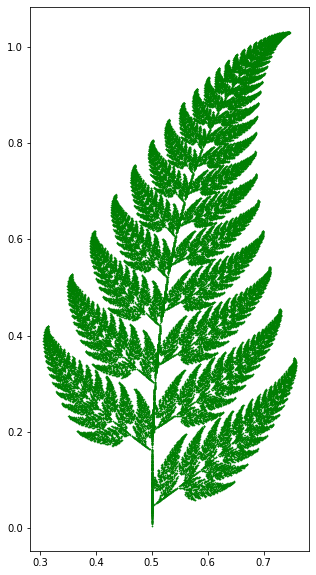

In [13]:
plt.figure(figsize=(5, 10))
plt.scatter(points[10:,0], points[10:,1], s=0.2, edgecolor='green')

In [14]:
sess2.close()

#### TensorFlow is not suitable to this fractal generation using IFS.  Points generation cannot be parallelised as each point is calculated based on the previous point, hence, the code is excuted serially.  Performance is many times better when using only numpy library as below: 

## Part 3
### (NumPy only)